In [28]:
#Importing the Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture,GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [29]:
df=pd.read_csv("/kaggle/input/th1-gaussion/Gia SMP va SMPcap 2021(Gi th trng SMP).csv", encoding='ISO-8859-1', delimiter=';')

In [30]:
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [31]:
feats=['13','14']
df[feats].tail()

,13,14
360,1002.0,1002.1
361,1002.0,1002.0
362,1061.5,1061.5
363,1022.6,1022.6
364,1022.6,1022.6


In [32]:
transformer = PowerTransformer()
X=transformer.fit_transform(df[feats])

In [33]:
pca = PCA(n_components=2,random_state=1)
pca.fit(X)
PCA_ds = pd.DataFrame(pca.transform(df[feats]), columns=(["col1","col2"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,365.0,-1471.171044,148.693807,-2213.869623,-1501.202394,-1446.121416,-1397.757097,-1252.522725
col2,365.0,12.641343,1.276898,10.761242,12.009046,12.424575,12.927585,19.020802


In [34]:
PCA_ds.tail()

,col1,col2
360,-1417.059792,12.245601
361,-1416.989692,12.174285
362,-1501.132293,12.897210
363,-1446.121416,12.424575
364,-1446.121416,12.424575


In [35]:
BGM = BayesianGaussianMixture(n_components=2,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(X)
PCA_ds["Clusters"] = preds
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= preds

In [36]:
pp=BGM.predict_proba(X)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(X,columns=feats) 
df_new[[f'predict_proba_{i}' for i in range(2)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(2):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [37]:
#ricopue's notebook's code snippet
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index][feats]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':7} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx],feature_name = feats)
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx],feature_name = feats)
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=300, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15
[200]	valid_0's multi_logloss: 6.66134e-15


In [38]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new[feats])

In [39]:
labels=np.argmax(lgb_preds,axis=1)

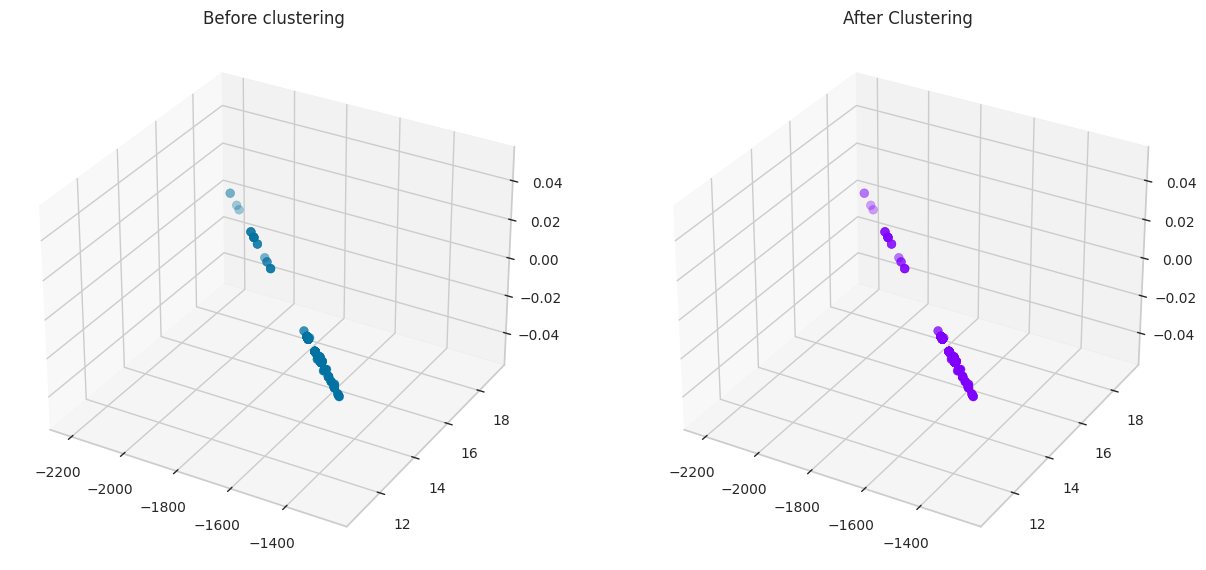

In [40]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'], s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(PCA_ds['col1'],PCA_ds['col2'],s=40, c=PCA_ds["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

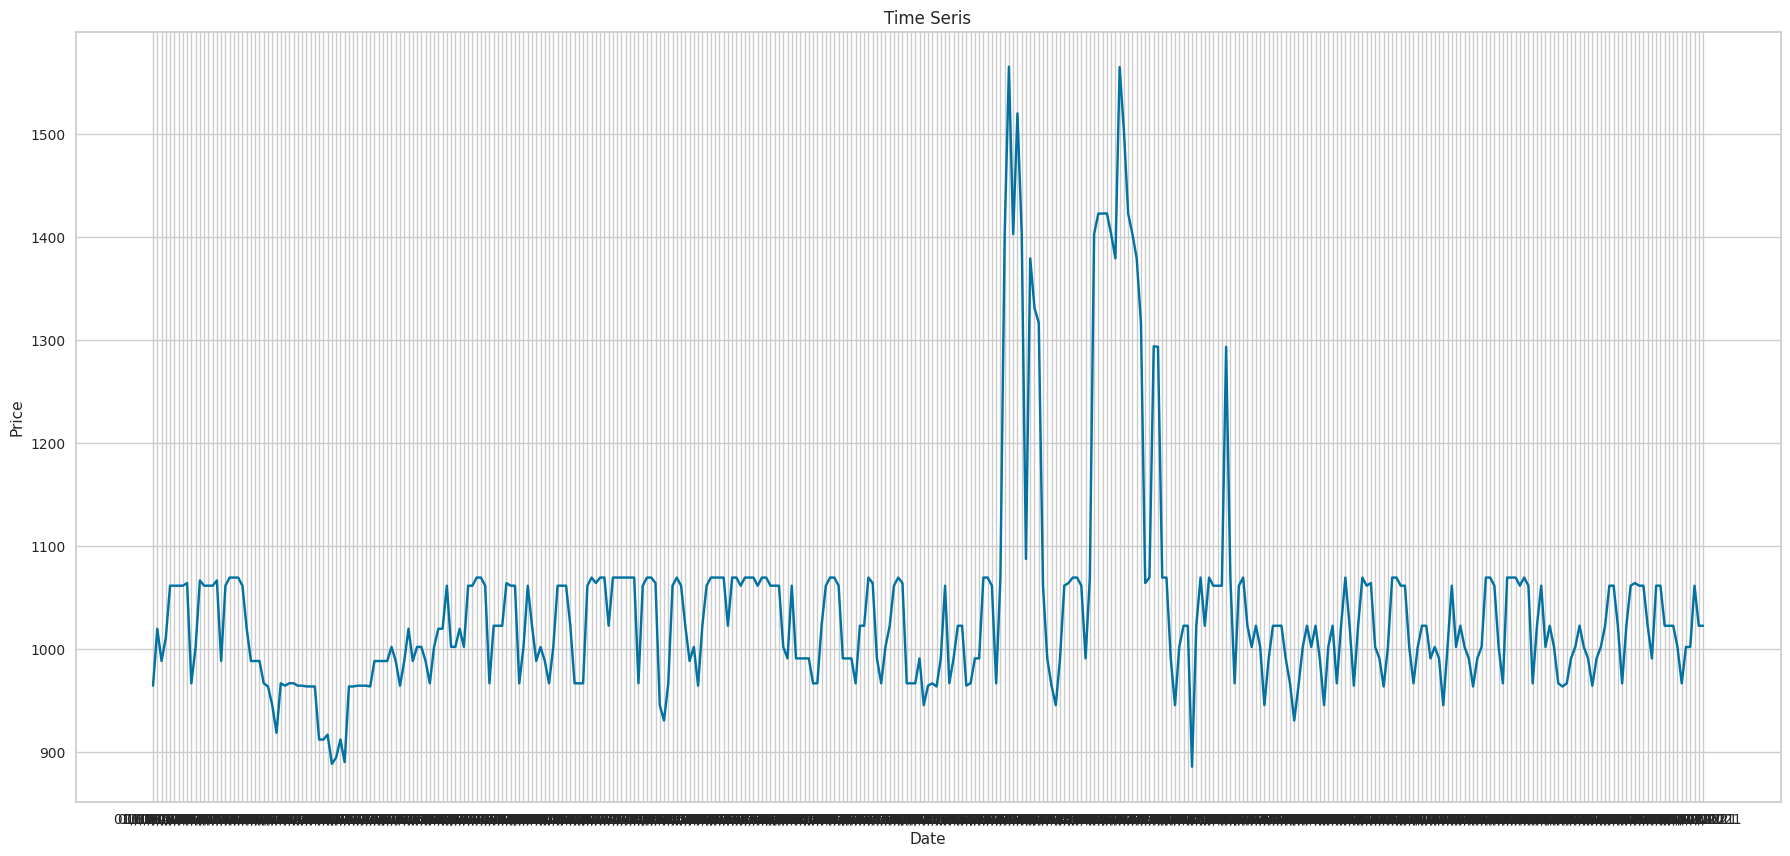

In [41]:
# Mean temperature of Bindikuri area
plt.figure(figsize=(22,10))
plt.plot(df['Ngày'],df['13'])
plt.title("Time Seris")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

# lets create time series from weather 
timeSeries = df.loc[:, ["Ngày","13"]]
timeSeries.index = df['Ngày']
ts = timeSeries.drop("Ngày",axis=1)

In [49]:
# ARIMA LİBRARY
from statsmodels.tsa.arima.model import ARIMA


# fit model
model = ARIMA(ts, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit = model.fit()



/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



In [53]:
# predict all path
from sklearn.metrics import mean_squared_error
# fit model
model2 = ARIMA(df, order=(1,0,1)) # (ARMA) = (1,0,1)
model_fit2 = model2.fit()
forecast2 = model_fit2.predict()
error = mean_squared_error(df, forecast2)
print("error: " ,error)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).